# Determining the cost of cars

The service for selling used cars “Not a Bit, Not a Paint” is developing an application to attract new customers. Here you can quickly find out the market value of your car. Historical data is at your disposal: technical characteristics, configurations and prices of cars. You need to build a model to determine the cost. 

*Important for the customer:*

- quality of prediction;
- prediction speed;
- studying time.

*Features:*

DateCrawled — date of downloading the questionnaire from the database

VehicleType — car body type

RegistrationYear — car registration year

Gearbox — gearbox type

Power — power (horsepower)

Model — сar model

Kilometer — car mileage (km)

RegistrationMonth — month of car registration

FuelType — fuel type

Brand — car model

Repaired — whether the car was repaired or not

DateCreated — date of creation of the questionnaire

NumberOfPictures — number of car photos

PostalCode — postal code of the application owner (user)

LastSeen — date of last user activity

Target

Price — price (EUR)

*Work plan:*

1. Download data
2. Explore the data. Fill missing values and handle anomalies in columns. 
3. Prepare samples for training models.
4. Train models
* LinearRegression
* RandomForestRegressor
* CatBoostRegressor
* LightGBM
4. Analyze training time, prediction time and quality of models.
5. Based on the customer’s criteria, choose the best model, check its quality on a test sample.

*Note:*

1. To assess the quality of models, apply a metric RMSE.
2. Metric value RMSE should be less 2500.
3. The gradient boosting model can take a long time to train, so it only needs to change two or three parameters.

## Data preparation

In [1]:
# download the libraries
import pandas as pd
import numpy as np
import datetime
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import OrdinalEncoder
import time
from lightgbm import LGBMRegressor
import sklearn
import inspect
from category_encoders import MEstimateEncoder

 from category_encoders import MEstimateEncoder
#---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
/tmp/ipykernel_742/3800338789.py in <module>
     16 import sklearn
     17 import inspect
---> 18 import category_encoders
     19 from category_encoders import MEstimateEncoder

ModuleNotFoundError: No module named 'category_encoders'
    

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load the data and display it on the screen
df = pd.read_csv('C:/Users/hp/Documents/data_science/GitHub/Yandex_project/Датасеты/autos.csv')
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


the table has 16 columns and more than 300,000 rows. We can already see that there are gaps in the cells.

In [4]:
# display information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

info() shows that there are gaps in a large number of data columns in our dataframe. Let's work through these points.

In [5]:
# let's look at the gaps
df.isnull().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
Repaired             0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Missing values in the columns "Car body type", "Gearbox type", "Car model", "Fuel type", "Has the car been repaired...". Next, let's see what we should do with these passes.

In [6]:
# let's look at the correlation matrix
df.corr().style.background_gradient(cmap='coolwarm')

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,nan,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,nan,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,nan,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,nan,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,nan,0.013995
NumberOfPictures,nan,nan,nan,nan,nan,nan,nan
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,nan,1.000000


In [7]:
# Let's look at the statistical information
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


There are lines with zero in Price. There is also zero data in the Power column, as well as a very high max for this column. We will display this data separately.

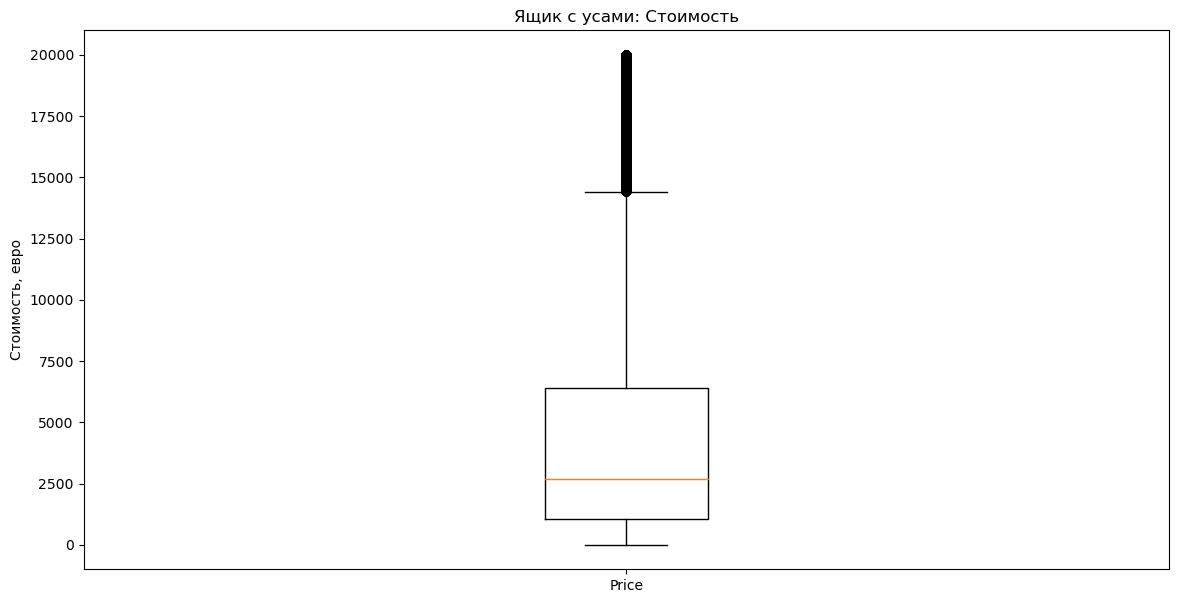

In [8]:
# Box plot
df_plt = df['Price']
plt.figure(figsize=(14,7))
plt.boxplot(df_plt)
plt.xticks([1],['Price'])
plt.title('Ящик с усами: Стоимость')
plt.ylabel('Стоимость, евро')
plt.show()

We see a long tail outside 15000.

In [9]:
# Let's see how many cars cost up to 100 EUR
df[df['Price'] < 100]['Price'].count()

13314

In [10]:
# Let's see what percentage of lines are less than 100 EUR in Price
df.query('Price<100').shape[0]/df.shape[0]*100

3.757100649323163

The number of lines where the cost of the car is indicated below 100 EUR is 3.76% of the total number of lines. But nevertheless, we will not delete these lines; perhaps there really are cars on sale with such a low cost (for spare parts).

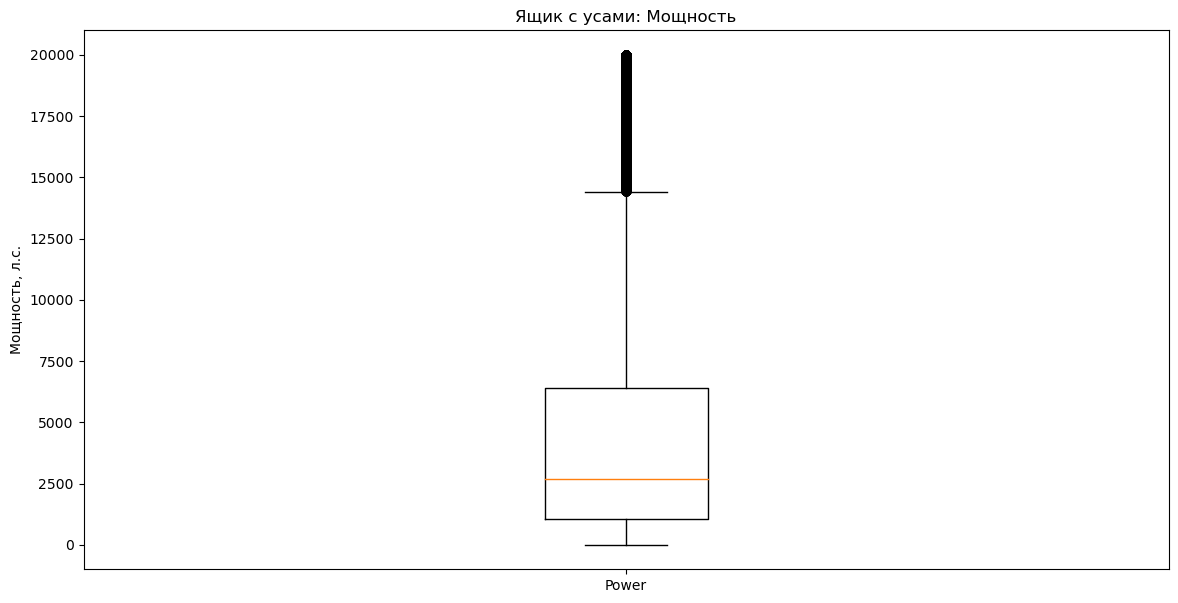

In [11]:
# Let's look at the outlier values for the Power column
# Let's build a Box plot with whiskers and look at the data distribution
df_plt_1=df['Power']
plt.figure(figsize=(14,7))
plt.boxplot(df_plt)
plt.xticks([1],['Power'])
plt.title('Ящик с усами: Мощность')
plt.ylabel('Мощность, л.с.')
plt.show()

We see completely strange power figures. The fastest cars in the World, sold exclusively, have no more than 2000 hp. Minimum - 17. Therefore, when preparing information, we will rely on these figures.

In [12]:
# Let's see what percentage are lines less than 17 and more than 2000 h.p. in Power
(df.query('2000 < Power').shape[0] + df.query('17 > Power').shape[0])/df.shape[0]*100


11.482099167816598

Percentage of data with power less than 17 and more than 2000 h.p. is approximately 10%. So let's delete the lines.

In [13]:
# Let's discard rows with values less than 17 and more than 2000 h.p.
df = df.query('17 <= Power <= 2000')
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,313680.000000,313680.000000,313680.000000,313680.000000,313680.000000,313680.0,313680.000000
mean,4705.565344,2003.468532,121.208231,128568.461489,5.934481,0.0,51024.373801
std,4591.511545,34.996617,64.212764,36732.386259,3.615682,0.0,25795.126315
min,0.000000,1000.000000,17.000000,5000.000000,0.000000,0.0,1067.000000
25%,1250.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30853.000000
50%,2999.000000,2003.000000,110.000000,150000.000000,6.000000,0.0,49824.000000
75%,6890.000000,2008.000000,150.000000,150000.000000,9.000000,0.0,71665.000000
max,20000.000000,9999.000000,2000.000000,150000.000000,12.000000,0.0,99998.000000


In [14]:
# Let's look at the max value for the DateCrawled column
df['DateCrawled'].agg(['min', 'max'])

min    2016-03-05 14:06:22
max    2016-04-07 14:36:58
Name: DateCrawled, dtype: object

In [15]:
# Let's look at the max value for the DateCreated column
df['DateCreated'].agg(['min', 'max'])

min    2015-03-20 00:00:00
max    2016-04-07 00:00:00
Name: DateCreated, dtype: object

In [16]:
# Let's look at the unique values for the RegistrationYear column
df['RegistrationYear'].unique()

array([2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 2016, 2007,
       2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1991, 1984, 2006,
       1999, 2012, 1994, 2010, 2000, 1992, 2013, 1996, 1989, 2015, 1993,
       1985, 1982, 1983, 1973, 1969, 1971, 1987, 1988, 1970, 1986, 1976,
       1965, 1945, 1974, 1955, 1978, 1979, 1972, 1977, 1961, 1975, 1968,
       1963, 1966, 1954, 1958, 1959, 1956, 1941, 1960, 1500, 1962, 1929,
       1957, 1910, 1940, 1964, 1967, 1949, 1937, 1800, 1953, 2019, 1234,
       2900, 6000, 5911, 1400, 4000, 8000, 1200, 1932, 1951, 1952, 1950,
       5000, 1942, 1935, 3000, 6500, 1000, 1930, 9999, 1943, 1938, 9000,
       1936, 1928, 2800, 1931, 1948, 4500, 1927, 1933, 8200, 1947, 1944,
       3500, 1600], dtype=int64)

So, we see that there are numbers that correspond to years from the future, there are years of past centuries 16, 15. Let's get rid of the lines that contain such strange data. We will leave the maximum year of registration as 2016, the month as March, since the latest deadline for the questionnaire is 04/07/2016, the minimum is 1970 (the year the first VAZ2101 was produced).

In [17]:
# Let's sort the table by RegistrationYear=2016 and RegistrationMonth of March and earlier
df1 = df.loc[((df['RegistrationYear'] == 2016) &(df['RegistrationMonth' ] <= 3))]
df1.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01 00:00:00,0,38871,2016-04-01 12:46:46
52,2016-04-04 10:57:36,1400,NaN,2016,manual,55,other,5000,1,NaN,hyundai,NaN,2016-04-04 00:00:00,0,34454,2016-04-06 12:45:43
79,2016-03-17 18:52:56,150,NaN,2016,manual,75,astra,150000,3,petrol,opel,yes,2016-03-17 00:00:00,0,78315,2016-04-05 03:45:22
181,2016-03-21 14:43:48,3000,NaN,2016,auto,75,fabia,150000,0,petrol,skoda,NaN,2016-03-21 00:00:00,0,24782,2016-03-31 17:45:24
281,2016-03-24 11:48:01,150,NaN,2016,auto,75,fiesta,50000,1,petrol,ford,yes,2016-03-24 00:00:00,0,32457,2016-03-30 11:48:26


In [18]:
# delete lines with a registration date in RegistrationYear older than 1970
# and younger than 2015
df = df.query('1970 <= RegistrationYear <= 2015')

df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,295388.000000,295388.000000,295388.000000,295388.000000,295388.000000,295388.0,295388.000000
mean,4795.660037,2002.548350,121.985741,128411.191382,5.990484,0.0,51179.889383
std,4620.818648,6.003247,63.502097,36670.143243,3.588883,0.0,25809.056287
min,0.000000,1970.000000,17.000000,5000.000000,0.000000,0.0,1067.000000
25%,1299.000000,1999.000000,77.000000,125000.000000,3.000000,0.0,30900.000000
50%,3100.000000,2003.000000,113.000000,150000.000000,6.000000,0.0,50226.000000
75%,6990.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,72070.500000
max,20000.000000,2015.000000,2000.000000,150000.000000,12.000000,0.0,99998.000000


In [19]:
# concat tables
df = pd.concat([df1, df]).sort_index(ascending = True)
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,298113.000000,298113.000000,298113.000000,298113.000000,298113.000000,298113.0,298113.000000
mean,4771.231818,2002.671309,121.792646,128449.883098,5.943947,0.0,51153.495738
std,4617.874351,6.111337,63.652880,36703.032301,3.606953,0.0,25806.714361
min,0.000000,1970.000000,17.000000,5000.000000,0.000000,0.0,1067.000000
25%,1250.000000,1999.000000,77.000000,125000.000000,3.000000,0.0,30890.000000
50%,3000.000000,2003.000000,113.000000,150000.000000,6.000000,0.0,50181.000000
75%,6950.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,71732.000000
max,20000.000000,2016.000000,2000.000000,150000.000000,12.000000,0.0,99998.000000


In [20]:
# We will display information on mileage equal to 5000 km
df.query('Kilometer == 5000')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
28,2016-03-09 11:56:38,1990,bus,1981,manual,50,transporter,5000,1,petrol,volkswagen,no,2016-03-09 00:00:00,0,87471,2016-03-10 07:44:33
52,2016-04-04 10:57:36,1400,NaN,2016,manual,55,other,5000,1,NaN,hyundai,NaN,2016-04-04 00:00:00,0,34454,2016-04-06 12:45:43
157,2016-03-23 14:45:57,7500,suv,2007,auto,194,sorento,5000,11,petrol,kia,NaN,2016-03-23 00:00:00,0,34314,2016-04-05 15:47:51
291,2016-04-01 00:51:10,2000,sedan,2004,manual,122,6_reihe,5000,7,gasoline,mazda,no,2016-03-31 00:00:00,0,54558,2016-04-05 00:44:27
736,2016-03-31 00:28:47,1290,bus,2001,manual,101,transit,5000,6,gasoline,ford,NaN,2016-03-29 00:00:00,0,35435,2016-04-02 21:11:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353456,2016-03-16 20:55:51,8500,small,2016,manual,69,c1,5000,3,petrol,citroen,no,2016-03-16 00:00:00,0,49716,2016-04-07 07:46:21
353523,2016-03-16 20:57:43,10000,small,1991,manual,174,NaN,5000,4,petrol,volkswagen,no,2016-03-16 00:00:00,0,74379,2016-03-29 01:47:33
353807,2016-03-20 14:48:13,2499,wagon,2002,auto,150,a6,5000,4,gasoline,audi,yes,2016-03-20 00:00:00,0,76889,2016-04-06 18:18:24
354079,2016-03-31 13:39:54,10985,small,2015,manual,82,1_reihe,5000,11,petrol,peugeot,no,2016-03-31 00:00:00,0,66128,2016-04-06 05:46:51


We see a discrepancy between the year of registration and the mileage of some cars. It is acceptable that a car can run no more than 2000 km per year (you need to pay attention to the year of registration, the date of creation of the questionnaire and the mileage), so for a car from 1981 the mileage of 5000 km is very small. Let’s assume that even older cars may have low mileage and we won’t delete any lines.

In [21]:
# Let's bring the DateCreated column to the form where we will leave 
# only the year the questionnaire was created
df['DateCreated'] = pd.DatetimeIndex(df['DateCreated']).year
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016,0,33775,2016-04-06 19:17:07


In [22]:
# Let's convert DateCreated to int to be able to perform further calculations
df['DateCreated'] = df['DateCreated'].astype(str).astype(int)

In [23]:
# let's get rid of NaN
df = df.fillna('unknoun')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298113 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        298113 non-null  object
 1   Price              298113 non-null  int64 
 2   VehicleType        298113 non-null  object
 3   RegistrationYear   298113 non-null  int64 
 4   Gearbox            298113 non-null  object
 5   Power              298113 non-null  int64 
 6   Model              298113 non-null  object
 7   Kilometer          298113 non-null  int64 
 8   RegistrationMonth  298113 non-null  int64 
 9   FuelType           298113 non-null  object
 10  Brand              298113 non-null  object
 11  Repaired           298113 non-null  object
 12  DateCreated        298113 non-null  int32 
 13  NumberOfPictures   298113 non-null  int64 
 14  PostalCode         298113 non-null  int64 
 15  LastSeen           298113 non-null  object
dtypes: int32(1), int64(7

In [24]:
# check the table for duplicates
display(df[df.duplicated() == True])
df.duplicated().sum()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016,0,36391,2016-03-18 18:46:15


4

In [25]:
# remove duplicates
df.drop_duplicates(inplace=True)

In [26]:
# remove columns that do not affect the result of the model
# get rid of signs that do not affect the target sign:
df.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'],
           axis=1,
           inplace=True)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,unknoun,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknoun
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Conclusion:

Conducted data preprocessing. The columns Price, Power, RegistrationYear, Kilometer were cleared of outlier values, both small and large.

NaN in the columns was assigned to the other group, where this group was present; in unknown, where there was no other group.

We checked for duplicates, found 4, but did not delete them, since upon closer examination the differences are visible.

Removed columns 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen' as columns that do not have the knowledge to train the model.

## Model training

### Preparing data for training

In [27]:
# highlight the features and the target feature
features = df.drop('Price', axis=1)
target = df['Price']

display(features)
display(target)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,coupe,2011,manual,190,unknoun,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,unknoun
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...
354359,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no
354362,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


1         18300
2          9800
3          1500
4          3600
5           650
          ...  
354359     7900
354362     3200
354366     1199
354367     9200
354368     3400
Name: Price, Length: 298109, dtype: int64

#### Feature encoding

In [28]:
# OHE
columns = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Kilometer', 'FuelType', 'Repaired']
features_ohe_trans = pd.get_dummies(features[columns], drop_first=True)

# add columns Model and Brand
features_ohe = pd.concat([features['Model'], features['Brand'] , features_ohe_trans], axis=1)
display(features_ohe)

,Model,Brand,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Gearbox_unknoun,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknoun,Repaired_unknoun,Repaired_yes
1,unknoun,audi,2011,190,125000,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,grand,jeep,2004,163,125000,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,golf,volkswagen,2001,75,150000,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,fabia,skoda,2008,69,90000,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
5,3er,bmw,1995,102,150000,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354359,golf,volkswagen,2010,140,150000,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
354362,leon,seat,2004,225,150000,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
354366,fortwo,smart,2000,101,125000,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
354367,transporter,volkswagen,1996,102,150000,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [29]:
# raining and validation samples - size 60/40
f_ohe_train, f_ohe_val, t_ohe_train, t_ohe_val = train_test_split(features_ohe, target,
                                                                            test_size=0.40,
                                                                            random_state=12345)
# validation and test samples - size 20/20. We divide the validation
f_ohe_test, f_ohe_val, t_ohe_test, t_ohe_val = train_test_split(f_ohe_val, t_ohe_val,
                                                                            test_size=0.50,
                                                                            random_state=12345)
print('Размер выборок с признаками:',f_ohe_train.shape, f_ohe_val.shape, f_ohe_test.shape)

print('Размер выборок с целевым признаком:',t_ohe_train.shape, t_ohe_val.shape, t_ohe_test.shape)

Размер выборок с признаками: (178865, 24) (59622, 24) (59622, 24)
Размер выборок с целевым признаком: (178865,) (59622,) (59622,)


In [30]:
# use MEstimateEncoder to encode the Brand and Model columns

m_encoder = MEstimateEncoder(cols=['Brand', 'Model']).fit(f_ohe_train, t_ohe_train)
f_ohe_train = m_encoder.transform(f_ohe_train)
f_ohe_val = m_encoder.transform(f_ohe_val)
f_ohe_test = m_encoder.transform(f_ohe_test)

f_ohe_train.shape

(178865, 24)

### StandardScaler

In [31]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,unknoun,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unknoun
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [32]:
# let's fix the numerical characteristics in numeric
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'Model', 'Brand']
# let's scale it up
scaler = StandardScaler()
scaler.fit(f_ohe_train[numeric])
# transform the samples using the transform function
f_ohe_train[numeric] = scaler.transform(f_ohe_train[numeric])
f_ohe_val[numeric] = scaler.transform(f_ohe_val[numeric])
f_ohe_test[numeric] = scaler.transform(f_ohe_test[numeric])
# display selections
display(f_ohe_train.head())
display(f_ohe_val.head())
display(f_ohe_test.head())

,Model,Brand,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Gearbox_unknoun,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknoun,Repaired_unknoun,Repaired_yes
153972,-0.114955,-0.003710,0.545926,0.761470,0.585534,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
4865,-0.576041,-0.003710,0.382218,-0.265664,0.585534,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
16759,0.759446,1.207262,1.364465,0.872084,-1.327498,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
31939,-0.434413,-0.734729,-0.436320,-1.071569,-0.780917,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
284757,2.138694,2.934486,1.528173,0.002971,-2.147369,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


,Model,Brand,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Gearbox_unknoun,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknoun,Repaired_unknoun,Repaired_yes
236163,0.759446,1.207262,1.200757,0.761470,0.585534,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
307254,-0.644419,-0.539272,0.382218,-0.502695,0.585534,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
185656,-0.006649,-0.003710,0.709634,0.761470,0.585534,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
206023,0.198291,1.143350,0.545926,0.650856,0.585534,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
151089,-0.006649,-0.003710,-0.763736,0.445429,0.585534,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,1


,Model,Brand,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Gearbox_unknoun,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,FuelType_unknoun,Repaired_unknoun,Repaired_yes
164067,-1.284485,-0.874323,1.037049,-0.834538,-0.780917,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
35924,-0.601992,-0.922021,0.218511,-0.739725,0.585534,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
240447,2.138694,2.934486,0.545926,-0.028633,-0.097692,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
129575,-1.330172,-1.500285,-0.600028,-1.134777,0.585534,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
230808,0.466821,0.945202,-1.418567,-0.739725,0.585534,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


### LinearRegression

In [33]:
%%time

start = time.time()
model_lr_ohe = LinearRegression()
model_lr_ohe.fit(f_ohe_train, t_ohe_train)

end = time.time()
eval_time_lr_l = end-start

CPU times: total: 344 ms
Wall time: 228 ms


In [34]:
%%time

start = time.time()

predict_lr_ohe = model_lr_ohe.predict(f_ohe_val)
rmse_lr_ohe = mean_squared_error(t_ohe_val, predict_lr_ohe) **0.5
end = time.time()
eval_time_lr_p = end-start

round(rmse_lr_ohe, 2)

CPU times: total: 31.2 ms
Wall time: 25.9 ms


2788.48

### RandomForestRegressor

In [35]:
%%time

start = time.time()

model_rfr = RandomForestRegressor(random_state=12345, n_estimators=10, 
                                  criterion='friedman_mse')
model_rfr.fit(f_ohe_train, t_ohe_train)
for m in model_rfr:
    hyperparams = inspect.signature(m.__init__)
    print(hyperparams)

end = time.time()
eval_time_rfr_l = end-start

(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)
(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)
(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)
(*, criterion='squared_error', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, ccp_alpha=0.0)
(*, criterion='squared_error', splitter='best', max_dept

In [36]:
 %%time

start = time.time()

predict_rfr = model_rfr.predict(f_ohe_val)
rmse_rfr = mean_squared_error(t_ohe_val, predict_rfr) **0.5
 
end = time.time()
eval_time_rfr_p = end-start
print('RMSE:', round(rmse_rfr, 2))


RMSE: 1696.84
CPU times: total: 281 ms
Wall time: 310 ms


###  CatBoostRegressor

In [37]:
%%time
start = time.time()

model_cb = CatBoostRegressor(random_state=123, learning_rate=0.4 , verbose=100 ,n_estimators=1000)
model_cb.fit(f_ohe_train, t_ohe_train)


end = time.time()
eval_time_cb_l = end-start

0:	learn: 3473.1786227	total: 224ms	remaining: 3m 43s
100:	learn: 1675.8472754	total: 2.66s	remaining: 23.7s
200:	learn: 1602.3393812	total: 4.98s	remaining: 19.8s
300:	learn: 1557.6907170	total: 7.3s	remaining: 17s
400:	learn: 1520.7548271	total: 9.63s	remaining: 14.4s
500:	learn: 1496.2944892	total: 11.9s	remaining: 11.8s
600:	learn: 1474.8753539	total: 14.2s	remaining: 9.44s
700:	learn: 1456.7152306	total: 16.5s	remaining: 7.03s
800:	learn: 1440.3263148	total: 18.8s	remaining: 4.68s
900:	learn: 1425.4434912	total: 21.1s	remaining: 2.32s
999:	learn: 1411.7423356	total: 23.4s	remaining: 0us
CPU times: total: 1min 30s
Wall time: 24 s


In [38]:
%%time
start = time.time()

predict_cb = model_cb.predict(f_ohe_val)
rmse_cb = mean_squared_error(t_ohe_val, predict_cb) **0.5

end = time.time()
eval_time_cb_p = end-start
print('RMSE:', round(rmse_cb, 2))

RMSE: 1624.28
CPU times: total: 125 ms
Wall time: 62.8 ms


### LightGBMRegressor

In [39]:
%%time

start = time.time()

model_lgbm = LGBMRegressor(n_estimators=100, random_state=12345, learning_rate=0.4)
model_lgbm.fit(f_ohe_train, t_ohe_train)

end = time.time()
eval_time_lgbm_l = end-start

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 178865, number of used features: 24
[LightGBM] [Info] Start training from score 4765.414983
CPU times: total: 2.08 s
Wall time: 1.21 s


In [40]:
%%time

start = time.time()

predict_lgbm = model_lgbm.predict(f_ohe_val)
rmse_lgbm = mean_squared_error(t_ohe_val, predict_lgbm) **0.5

end = time.time()
eval_time_lgbm_p = end-start
print('RMSE:', round(rmse_lgbm, 2))

RMSE: 1674.47
CPU times: total: 375 ms
Wall time: 202 ms


Conclusion: 

We prepared the signs for training. OHE coding translated categorical into numeric features. We scaled the numerical features, since the features had a large range from 1 to thousands. Next, the LinearRegression, RandomForestRegressor, CatBoostRegressor, and LightGBMRegressor models were trained on the prepared samples.

## Model Analysis

In [41]:
# Let's put the data into a table
index = ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LightGBMRegressor']
data = {'RMSE':  [rmse_lr_ohe, rmse_rfr, rmse_cb, rmse_lgbm],
        'Время обучения':  [eval_time_lr_l, eval_time_rfr_l,  eval_time_cb_l, eval_time_lgbm_l],
        'Время предсказания': [eval_time_lr_p, eval_time_rfr_p,  eval_time_cb_p, eval_time_lgbm_p]
       }
data_analysis = pd.DataFrame(data=data, index=index)
display(data_analysis)

,RMSE,Время обучения,Время предсказания
LinearRegression,2788.478803,0.228309,0.025930
RandomForestRegressor,1696.844003,13.562713,0.309171
CatBoostRegressor,1624.282839,23.995847,0.062830
LightGBMRegressor,1674.473142,1.213307,0.202462


 In terms of RMSE, CatBoostRegressor wins (1624.28). The model training time is the highest, in terms of training it is in last place, and in terms of prediction it is in second place. LGBM is in second place in terms of quality and time spent on training and prediction. I would suggest using CatBoostRegressor for testing, since with a longer training time it has a faster time compared to LightGBMRegressor and a lower RMSE.

In [42]:
# Let's check CatBoostRegressor on a test sample

In [43]:
%%time
start = time.time()

predict_cb = model_cb.predict(f_ohe_test)
rmse_cb = mean_squared_error(t_ohe_test, predict_cb) **0.5

end = time.time()
eval_time_cb_p = end-start
print('RMSE:', round(rmse_cb, 2))

RMSE: 1625.24
CPU times: total: 234 ms
Wall time: 71.8 ms


Conclusion:

1. During the work, we preprocessed the data. The columns Price, Power, RegistrationYear, Kilometer were cleared of outlier values, both small and large.

NaN in all columns was classified as unknown.

We checked for duplicates, found 4, but did not delete them, since upon closer examination the differences are visible.

Removed columns 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen' as columns that are not relevant for model training.

During preprocessing, the approximate amount of data removed is 10% of the total data.

2. When preparing the data, we divided it into three samples: training, validation and test. The test one makes up 10% of the entire dataset.

Conducted coding of the following signs. columns 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Kilometer', 'FuelType', 'Repaired' get_dummies.
Used MEstimateEncoder to encode the Brand and Model columns since these columns contain a large number of unique values.
Scaling StandardScaler 'RegistrationYear', 'Power', 'Kilometer', 'Model', 'Brand'.

Trained LinearRegression, RandomForestRegressor, CatBoostRegressor, LightGBMRegressor models.
We got the following results during training:
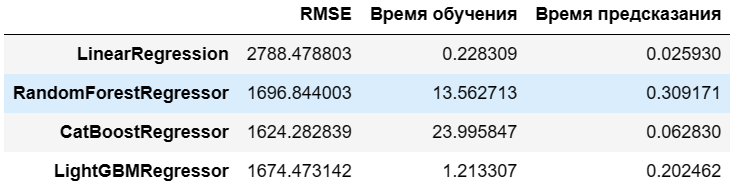

We chose CatBoostRegressor for testing, since with a longer training time it has a faster time compared to LightGBMRegressor and a lower RMSE.

In the test this model showed:
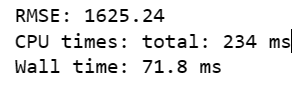

The RMSE performance target should not exceed 2500.
We have achieved our goal.